Середній час поїздки у хвилинах по годинах доби в залежності від відстані за останні 7 днів

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr

# Create SparkSession
spark = SparkSession.builder \
    .appName("SimpleApp") \
    .getOrCreate()



your 131072x1 screen size is bogus. expect trouble
25/04/16 12:51:09 WARN Utils: Your hostname, DESKTOP-DP2FLCF resolves to a loopback address: 127.0.1.1; using 172.22.104.161 instead (on interface eth0)
25/04/16 12:51:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/16 12:51:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/16 12:51:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
df_fare_init = spark.read.option("header", True).option("inferSchema", True).csv("../data_lake/trip_fare_1.csv")
df_trip_init = spark.read.option("header", True).option("inferSchema", True).csv("../data_lake/trip_data_1.csv")

In [3]:
for column in df_fare_init.columns:
    df_fare_init = df_fare_init.withColumnRenamed(column, column.strip().replace(" ", "_"))

In [4]:
from pyspark.sql.functions import to_date, lit

df_trip = df_trip_init.filter(
    (col("passenger_count") > 0) & (col("passenger_count") <= 10) &
    (col("trip_time_in_secs") > 0) &
    (col("trip_distance") > 0) &
    (col("pickup_latitude").between(40.5, 41.0)) &
    (col("dropoff_latitude").between(40.5, 41.0)) &
    (col("pickup_longitude").between(-74.5, -73.0)) &
    (col("dropoff_longitude").between(-74.5, -73.0)) &
    (col("pickup_datetime") <= lit("2013-01-27"))
)

df_fare = df_fare_init.filter(
    (col("fare_amount") >= 0) &
    (col("tip_amount") >= 0) &
    (col("tolls_amount") >= 0) &
    (col("total_amount") >= 0) &
    ((col("fare_amount") > 0) | (col("payment_type") == "NOC")) &
    (col("pickup_datetime") <= lit("2013-01-27"))
)

In [5]:
from pyspark.sql.functions import col, hour, when, to_date, max as Fmax, date_sub, expr, avg, round


In [6]:
week_start = date_sub(lit("2013-01-27"), 6)

In [7]:
df_week = df_trip.withColumn("trip_date", to_date("pickup_datetime")) \
    .filter((col("trip_date") >= week_start) & (col("trip_time_in_secs") > 0))

df_categorized = df_week.withColumn("hour", hour("pickup_datetime")) \
    .withColumn("distance_category", when(col("trip_distance") < 3, "0–3")
                                     .when((col("trip_distance") >= 3) & (col("trip_distance") < 6), "3–6")
                                     .when((col("trip_distance") >= 6) & (col("trip_distance") < 9), "6–9")
                                     .when((col("trip_distance") >= 9) & (col("trip_distance") < 12), "9–12")
                                     .when((col("trip_distance") >= 12) & (col("trip_distance") < 15), "12–15")
                                     .otherwise("15+"))

df_avg_time = df_categorized.groupBy("hour", "distance_category") \
    .agg(avg(col("trip_time_in_secs") / 60).alias("avg_trip_time_min"))

pdf = df_avg_time.orderBy("hour", "distance_category").toPandas()

In [8]:
df_pivoted = df_avg_time.groupBy("hour") \
    .pivot("distance_category", ["0–3", "3–6", "6–9", "9–12", "12–15", "15+"]) \
    .agg(round(avg("avg_trip_time_min"), 2))

df_pivoted = df_pivoted.orderBy("hour")

df_pivoted.show(24, truncate=False)

+----+----+-----+-----+-----+-----+-----+
|hour|0–3 |3–6  |6–9  |9–12 |12–15|15+  |
+----+----+-----+-----+-----+-----+-----+
|0   |6.86|14.72|20.5 |22.9 |26.79|29.11|
|1   |6.58|13.99|20.01|23.11|27.01|31.01|
|2   |6.37|13.84|19.87|23.28|27.29|32.4 |
|3   |6.25|13.7 |19.82|23.32|26.72|32.15|
|4   |5.9 |13.21|18.97|20.76|26.57|28.16|
|5   |5.39|12.46|17.65|19.88|24.16|29.26|
|6   |5.94|13.07|18.05|21.23|26.58|33.55|
|7   |7.43|16.09|20.86|25.24|31.46|40.83|
|8   |8.89|19.14|24.39|28.01|33.71|40.72|
|9   |9.37|19.37|23.07|26.97|31.65|35.57|
|10  |8.92|18.63|21.38|26.35|30.17|35.07|
|11  |8.92|18.9 |21.35|25.58|30.49|36.39|
|12  |8.89|18.98|21.11|25.16|30.12|37.96|
|13  |8.85|18.91|21.48|25.09|30.81|39.08|
|14  |9.06|19.64|22.42|26.65|32.36|40.64|
|15  |8.78|19.24|23.52|28.46|34.94|44.16|
|16  |8.09|18.16|23.99|29.39|36.56|45.65|
|17  |8.85|20.09|26.19|31.36|37.93|47.9 |
|18  |9.18|20.28|25.45|29.28|36.56|43.18|
|19  |8.68|18.86|23.05|25.87|31.79|35.84|
|20  |8.12|17.38|22.01|23.93|28.53

In [9]:
df_pivoted.coalesce(1).write.mode("overwrite").option("header", True).csv("./results/avg_trip_duration_by_hour.csv")

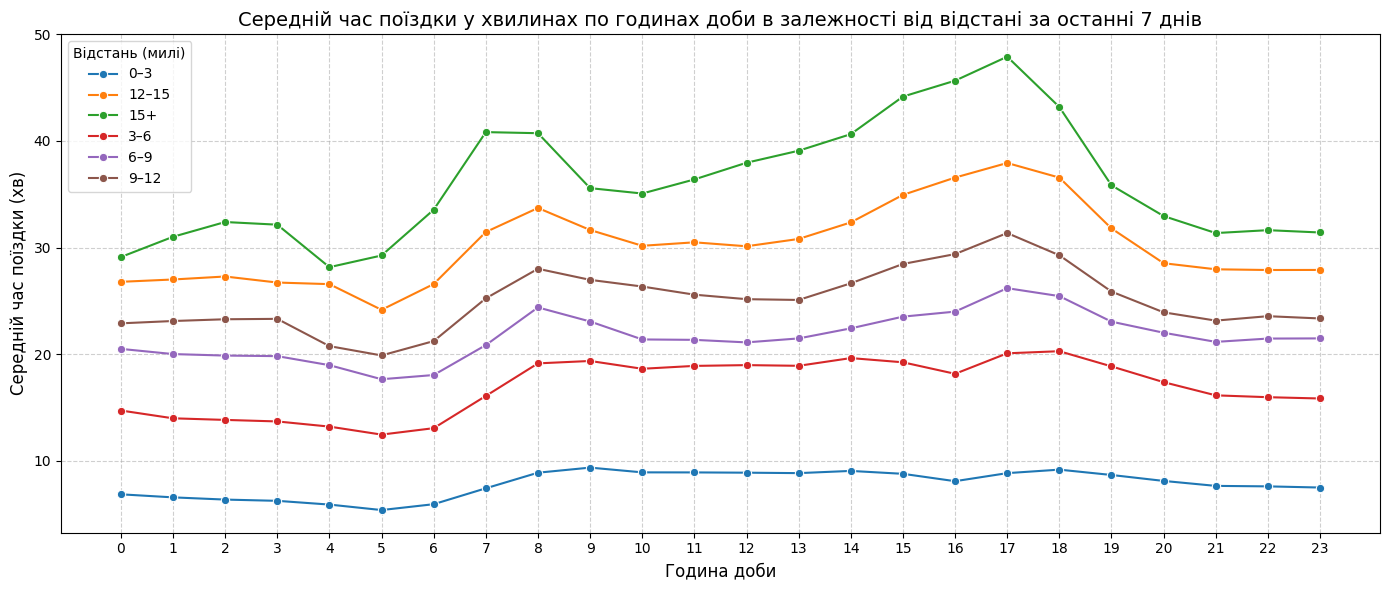

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.lineplot(data=pdf, x="hour", y="avg_trip_time_min", hue="distance_category", marker="o", palette="tab10")

plt.title("Середній час поїздки у хвилинах по годинах доби в залежності від відстані за останні 7 днів", fontsize=14)
plt.xlabel("Година доби", fontsize=12)
plt.ylabel("Середній час поїздки (хв)", fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Відстань (милі)", loc='upper left')

plt.tight_layout()
plt.show()
